# Setup

In [ ]:
!pip install torchmultimodal-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.5/256.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━

In [ ]:
import torch
import torchvision
import torchvision.transforms.functional as F

from torch import nn
from tqdm import tqdm
from torchmultimodal.diffusion_labs.modules.adapters.cfguidance import CFGuidance
from torchmultimodal.diffusion_labs.modules.losses.diffusion_hybrid_loss import DiffusionHybridLoss
from torchmultimodal.diffusion_labs.samplers.ddpm import DDPModule
from torchmultimodal.diffusion_labs.predictors.noise_predictor import NoisePredictor
from torchmultimodal.diffusion_labs.schedules.discrete_gaussian_schedule import linear_beta_schedule, DiscreteGaussianSchedule
from torchmultimodal.diffusion_labs.transforms.diffusion_transform import RandomDiffusionSteps
from torchmultimodal.diffusion_labs.utils.common import DiffusionOutput

# Schedule

In [ ]:
# Define Diffusion Schedule

schedule = DiscreteGaussianSchedule(linear_beta_schedule(1000))

# Predictor

In [ ]:
# Define Prediction Target

predictor = NoisePredictor(schedule, lambda x: torch.clamp(x, -1, 1))

# U-Net

```
from torchmultimodal.diffusion_labs.models.adm_unet.adm import adm_unet

unet = adm_unet(
    time_embed_dim=32,
    embed_dim=32,
    embed_name="context",
    predict_variance_value=True,
    image_channels=1,
)
```

In [ ]:
# Down scaling input blocks for unet
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_channels):
        super().__init__()
        # Define convolutions
        self.block =  nn.Sequential(
                nn.Conv2d(in_channels + cond_channels, out_channels, kernel_size = 3, padding = 1),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
                nn.ReLU()
            )
        self.pooling = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, c):
        _, _, w, h = x.size()
        c = c.expand(-1, -1, w, h)              # Shape conditional input to match image
        x = self.block(torch.cat([x, c], 1))    # Convolutions over image + condition
        x_small = self.pooling(x)               # Downsample output for next block
        return x, x_small

# Upscaling blocks on unet
class UpBlock(nn.Module):
    def __init__(self, inp, out):
        super().__init__()
        # Define convolutions
        self.block = nn.Sequential(
                nn.Conv2d(2*inp, out, kernel_size = 3, padding = 1),
                nn.ReLU(),
                nn.Conv2d(out, out, kernel_size = 3, padding = 1),
                nn.ReLU()
        )
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x, x_small):
        x_big = self.upsample(x_small)          # Upscale input back towards original size
        x = torch.cat((x_big, x), dim=1)        # Join previous block with accross block
        x = self.block(x)                       # Convolutions over image
        return x

class UNet(nn.Module):
    def __init__(self, time_size=32, digit_size=32, steps=1000):
        super().__init__()
        cond_size = time_size + digit_size
        self.conv = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.down = nn.ModuleList([DownBlock(128, 256, cond_size), DownBlock(256, 512, cond_size)])
        self.bottleneck = DownBlock(512, 512, cond_size)
        self.up = nn.ModuleList([UpBlock(512, 256), UpBlock(256, 128)])
        # Define UNet

        self.time_projection = nn.Embedding(steps, time_size)
        self.prediction = nn.Conv2d(128, 1, kernel_size=3, padding = 1)
        self.variance = nn.Conv2d(128, 1, kernel_size=3, padding = 1)

    # Define forward
    def forward(self, x, t, conditional_inputs):

        b, c, h, w = x.shape
        timestep = self.time_projection(t).view(b, -1, 1, 1)
        condition = conditional_inputs["context"].view(b, -1, 1, 1)
        condition = torch.cat([timestep, condition], dim = 1)

        x = self.conv(x)
        outs = []
        for block in self.down:
            out, x = block(x, condition)
            outs.append(out)
        x, _ = self.bottleneck(x, condition)

        for block in self.up:
            x = block(outs.pop(), x)
        v = self.variance(x)
        p = self.prediction(x)

        return DiffusionOutput(p, v)

# Diffusion Model

In [ ]:
unet = UNet(time_size=32, digit_size=32)
# Add support for classifier free guidance
unet = CFGuidance(unet, {"context": 32}, guidance = 2.0)

In [ ]:
# Define evalution
eval_steps = torch.linspace(0, 999, 250, dtype=torch.long)
classifier = DDPModule(unet, schedule, predictor, eval_steps)

In [ ]:
# Define conditional embeddings
encoder = nn.Embedding(10, 32)

# Data

In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Lambda

# Transform data and use RandomDiffusionSteps to sample random noise
diffusion_transform = RandomDiffusionSteps(schedule, batched = False)
transform = Compose([Resize(32),
                      ToTensor(),
                      Lambda(lambda x: 2*x - 1),
                      Lambda(lambda x: diffusion_transform({"x" : x}))])

In [ ]:
from torchvision.datasets import FashionMNIST
from torch.utils.dataset import DataLoader

train_dataset = FashionMNIST("fashion_mnist", training_data=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=192, shuffle=True, num_workers=2, pin_memory=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 167kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.04MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]


# Train

In [ ]:
epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
classifier.to(device)

# Apply optimizer to diffusion model and encoder for joint training
optimizer = torch.optim.AdamW(
    [{"params": encoder.parameters()}, {"params": classifier.parameters()}], lr=0.0001
)
# Define loss
h_loss = DiffusionHybridLoss(schedule)

encoder.training_data()
classifier.training_data()
for e in range(epochs):
    for sample in (pbar := tqdm(train_dataloader)):
        x, c = sample
        x0, xt, noise, t, c = x["x"].to(device), x["xt"].to(device), x["noise"].to(device), x["t"].to(device), c.to(device)
        optimizer.zero_grad()

        # Compute loss
        embedding = encoder(c)
        out = classifier(xt, t, {"context": embedding})
        loss = h_loss(out.prediction, noise, out.mean, out.log_variance, x0, xt, t)

        loss.backward()
        optimizer.step()

        pbar.set_description(f'{e+1}| Loss: {loss.item()}')

1| Loss: 0.0655328780412674: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]
2| Loss: 0.06686924397945404: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]
3| Loss: 0.0464119054377079: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]
4| Loss: 0.048935942351818085: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]
5| Loss: 0.042072661221027374: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]
6| Loss: 0.04983304440975189: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]
7| Loss: 0.03500033915042877: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]
8| Loss: 0.03705158829689026: 100%|██████████| 313/313 [02:45<00:00,  1.89it/s]
9| Loss: 0.03149774298071861: 100%|██████████| 313/313 [02:45<00:00,  1.90it/s]
10| Loss: 0.042329344898462296: 100%|██████████| 313/313 [02:45<00:00,  1.90it/s]
11| Loss: 0.031648777425289154: 100%|██████████| 313/313 [02:45<00:00,  1.90it/s]
12| Loss: 0.026399215683341026: 100%|██████████| 313/313 [02:45<00:00,  1.90it/s]
13| Loss: 0.03707490488886833: 100

# Generate

In [ ]:
def fashion_encoder(name, num=1):
    fashion_dict = {"t-shirt": 0, "pants": 1, "sweater": 2, "dress": 3, "coat": 4,
                    "sandal": 5, "shirt": 6, "sneaker": 7, "purse": 8, "boot": 9}
    idx = torch.as_tensor([fashion_dict[name] for _ in range(num)]).to(device)

    encoder.eval()
    with torch.no_grad():
        embed = encoder(idx)
    return embed

  0%|          | 0/250 [00:00<?, ?it/s]

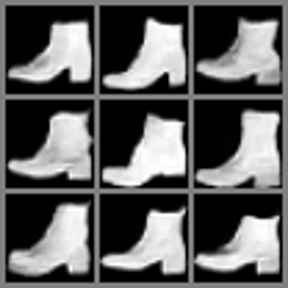

In [ ]:
classifier.eval()

c = fashion_encoder("boot", 9)
noise = torch.randn(size=(9,1,32,32)).to(device)

with torch.no_grad():
    imgs = classifier(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))

  0%|          | 0/250 [00:00<?, ?it/s]

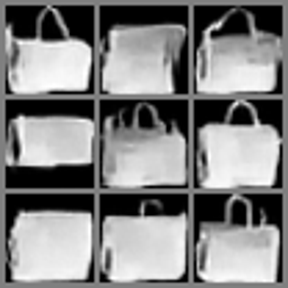

In [ ]:
classifier.eval()

c = fashion_encoder("purse", 9)
noise = torch.randn(size=(9,1,32,32)).to(device)

with torch.no_grad():
    imgs = classifier(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))

  0%|          | 0/250 [00:00<?, ?it/s]

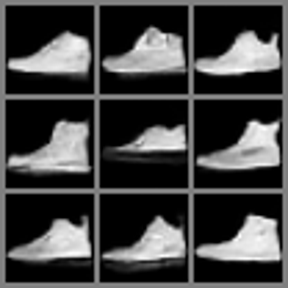

In [ ]:
classifier.eval()

c = 0.5*fashion_encoder("sneaker", 9) + 0.5*fashion_encoder("boot", 9)
noise = torch.randn(size=(9,1,32,32)).to(device)

with torch.no_grad():
    imgs = classifier(noise, conditional_inputs={"context": c})

img_grid = torchvision.utils.make_grid(imgs, 3)
img = F.to_pil_image((img_grid + 1) / 2)
img.resize((288, 288))

In [4]:
import json

notebook_path = "notebook.ipynb"  # change this if needed
cleaned_notebook_path = "cleaned_notebook.ipynb"

# Save a copy of the current notebook first (manually)
from google.colab import files

# Upload the notebook you want to clean (or download the current one from File > Download)
uploaded = files.upload()  # upload your .ipynb file

# Clean the widget metadata
with open(notebook_path, "r", encoding="utf-8") as f:
    dataset = json.load(f)

if "widgets" in dataset.get("metadata", {}):
    del dataset["metadata"]["widgets"]

with open(cleaned_notebook_path, "w", encoding="utf-8") as f:
    json.dump(dataset, f, indent=2)

print("Cleaned notebook saved as:", cleaned_notebook_path)

Saving solution.ipynb to solution (1).ipynb
Cleaned notebook saved as: cleaned_notebook.ipynb
